In [151]:
# auto-reload modules when they have changed
%reload_ext autoreload
%autoreload 2

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show, output_notebook, curdoc

In [153]:
from modules.load import image, timestamps
from modules.analyze import blinking_analyzer, FIDA_analyzer
from modules import plot

In [154]:
#plt.style.use('default')
plt.style.use('dark_background')
curdoc().theme = 'dark_minimal'
output_notebook()

Loading BokehJS ...

In [155]:
image_path = '/Users/kappel/Downloads/test_scan_image_parameters.img'
timestamps_path = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_03_29/tt_PMI_1e6_PMMA_5gl_10uW_77K_circpol_010.h5'

timestamps_path_single_detector = '/Users/kappel/Messungen/Setup04/JaKa/pre_hack/22_05_25/timetrace/timetracefromsinglemolecule03.H5'
timestamps_path_blinking = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_04_06_blinking/tt_PMI_PMMA_1e6_2dot5gl_sl6_30_uW_014.h5'

# create image object using image class from data loading modules
#img = image.load_from_path(image_path)
#img.preview()
#img.explore()


# create timestamps object using timestamps class from data loading modules
tt = timestamps.load_from_path(timestamps_path_blinking)
#tt.preview()
tt.explore(bin_width=0.01) 

# raw data
#tt.data['detector0']

# binned data would be useful, e.g. for FIDA analysis

23123


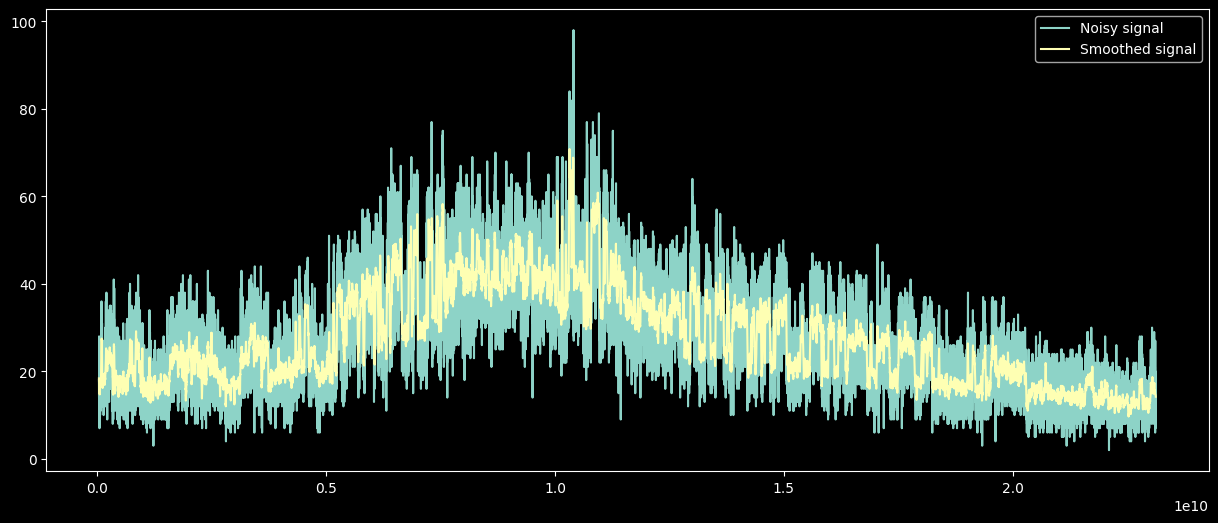

In [156]:
from scipy.signal import savgol_filter

# Generate noisy signal
t = np.linspace(0, 10, 1000)
x = np.sin(t) + np.random.normal(0, 0.1, len(t))

bin_width = 0.001

timestamps0 = tt.data['detector0'].to_numpy()
timetrace_len = timestamps0[-1]
timetrace_len_in_s = timetrace_len * 1e-9

n_bins = timetrace_len_in_s/bin_width
bins = int(np.floor(n_bins))

counts0, bins0 = np.histogram(timestamps0, bins=bins)
bins0 = bins0[0:-1]

# Smooth signal using Savitzky-Golay filter
smoothed = savgol_filter(counts0, 30, 3)
print(len(smoothed))

# Plot original and smoothed signal
plt.figure(figsize=(15,6))
plt.plot(bins0, counts0, label='Noisy signal')
plt.plot(bins0, smoothed, label='Smoothed signal')
plt.legend()
plt.show()

In [157]:
p = figure(width=1200, height=300, title='smoothing')
p.line(bins0*1e-9, np.append(counts0, 5), line_color='#517BA1')
p.line(bins0*1e-9, np.append(smoothed, 5), line_color='yellow')
show(p)

In [158]:
from scipy import sparse, signal
from scipy.sparse import linalg
import numpy as np
from numpy.linalg import norm


def baseline_arPLS(y, ratio=1e-6, lam=100, niter=10, full_output=False):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252

    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)

    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = norm(w_new - w) / norm(w)

        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        info = {'num_iter': count, 'stop_criterion': crit}
        return z, d, info
    else:
        return z

In [159]:
_, spectra_arPLS, info = baseline_arPLS(smoothed, lam=10000000000000, niter=100,
                                         full_output=True)

Maximum number of iterations exceeded


In [160]:
p = figure(width=1200, height=300, title='smoothing')
p.line(bins0*1e-9, np.append(counts0, 5), line_color='#517BA1')
p.line(bins0*1e-9, np.append(smoothed, 5), line_color='yellow')
p.line(bins0*1e-9, np.append(spectra_arPLS, 5), line_color='red')
show(p)

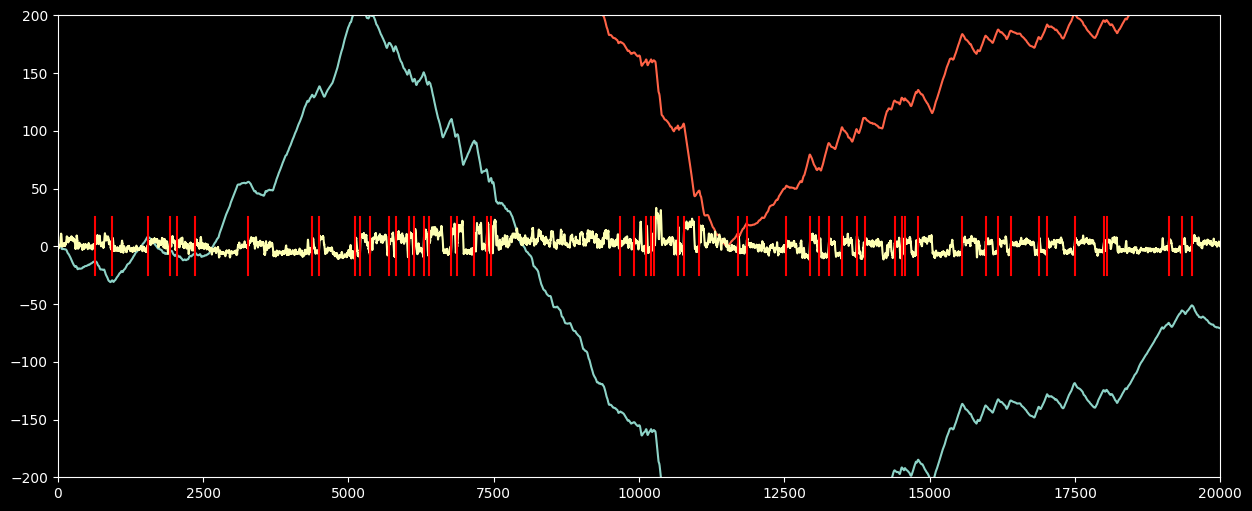

In [216]:
d = spectra_arPLS

# Convolution part
dary = np.array(d)
dary -= np.average(dary)

step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))

dary_step = np.convolve(dary, step, mode='valid')

ceil_dary_step = dary_step/100 - np.min(dary_step/100)

# Get the peaks of the convolution
peaks = signal.find_peaks(ceil_dary_step, width=20, rel_height=60, prominence=1.2)[0]

# plots
plt.figure(figsize=(15,6))



#plt.plot(dary)
#p.line(dary)

plt.plot(dary_step/100)
plt.plot(ceil_dary_step, 'tomato')
plt.plot(d)
plt.ylim(-200, 200)
plt.xlim(0, 20000)


for ii in range(len(peaks)):
    plt.plot((peaks[ii], peaks[ii]), (-25, 25), 'red')

plt.show()


In [205]:
timetrace_len_in_s  = timetrace_len * 1e-9
print(timetrace_len_in_s)
print(len(spectra_arPLS))

x = np.linspace(0, timetrace_len_in_s, len(spectra_arPLS))
print(len(x))


p = figure(width=1200, height=400, title='steps')


p.line(x, spectra_arPLS, line_color='#517BA1')
p.line(x, ceil_dary_step, line_color='yellow')

for ii in range(len(peaks)):
    #plt.plot((peaks[ii], peaks[ii]), (-40, 40), 'r')
    p.line((peaks[ii]*1e-3, peaks[ii]*1e-3), (-40, 40), line_color='red')

show(p)

23.123268258000003
23123
23123


In [163]:
print(d)
print(spectra_arPLS)
print(bins0)

[1.99410284 1.35850394 0.79925612 ... 2.16982193 2.05513242 1.9123742 ]
[1.99410284 1.35850394 0.79925612 ... 2.16982193 2.05513242 1.9123742 ]
[3.71144630e+07 3.81128695e+07 3.91112760e+07 ... 2.31202730e+10
 2.31212714e+10 2.31222699e+10]


In [164]:
print(len(d))

23123


In [165]:
print(len(bins0))

23123
